# baselines for mtl comparison

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from lib.train import InterpretableTrainer, Trainer
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.model import Switch, Weight, apply_linear
from lib.utility import logit_elementwise_loss
from lib.utility import plotDecisionSurface, to_var, to_np, check_nan, onehotize, to_cuda
from lib.utility import genCovX
from lib.model import WeightIndependent
from itertools import product
import os
from lib.parallel_run import map_parallel

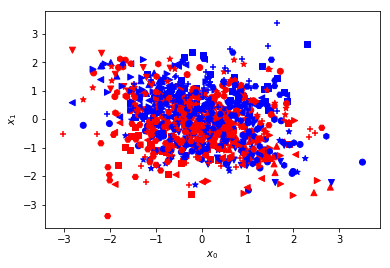

In [2]:
# instance: mtl_standard-0.05_ntask200_nswitch5_mtlTrue
def genTask(n=100):
    d = 20
    C = np.eye(d)
    cov = np.random.rand() * 2 - 1
    st = 1 if (np.random.rand()-0.5 > 0) else -1
    C[0,1] = C[1,0] = cov
    while True:
        X = genCovX(C, n)
        y = ((X[:,1] * st) >= 0).astype(np.int)
        if sum(y) > 0 and sum(y) < n: # has both positive and negative examples
            break
    return X, y*2-1, st

markers = [',','o','^','v','<','>','*','h','H','+']

for m in markers:
    X, y, st = genTask()
    colors = list(map(lambda a: 'b' if a==-1 else 'r', y))
    plt.scatter(X[:,0], X[:,1], c=colors, marker=m)
    
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.show()

In [3]:
ntasks = 200
train_n = 6
test_n = 1000
total_data = [genTask(n=train_n + test_n) for i in range(ntasks)]

# pos and neg tasks
pos_tasks = list(filter(lambda x: x[2] > 0, total_data))
neg_tasks = list(filter(lambda x: x[2] < 0, total_data))
print(len(pos_tasks), 'positive tasks')
total_data = list(enumerate(pos_tasks + neg_tasks))
print('total', len(total_data), 'tasks')

X = np.vstack(list(map(lambda x: np.hstack([x[1][0][:train_n], 
                                            x[0]*np.ones_like(x[1][0][:,:1])[:train_n]]), 
                        total_data)))
Y = np.hstack(list(map(lambda x: x[1][1][:train_n], 
                       total_data)))

Xtest = np.vstack(list(map(lambda x: np.hstack([x[1][0][train_n:], 
                                                x[0]*np.ones_like(x[1][0][:,:1])[train_n:]]), 
                           total_data)))
Ytest = np.hstack(list(map(lambda x: x[1][1][train_n:], 
                           total_data)))

113 positive tasks
total 200 tasks


In [4]:
def apply_linear_mtl(f, x):
    return apply_linear(f, x[:,:-1])

def task1(lr, alpha, beta, k, batch_size):
    mtl = True
    max_time = 5 # at most max_time minutes
    
    switch_size = k
    if mtl:
        input_size = 20
        task_size = ntasks # one hot representation
        apply_f = apply_linear_mtl
    else:
        input_size = 21
        task_size = input_size
        apply_f = apply_linear

    switch = Switch(task_size, switch_size, mtl=mtl)
    weight = WeightIndependent(switch_size, input_size+1) # +1 for b in linear model

    name = 'ind/lr%.3f/a%.3f/b%.3f/k%d/bs%d' % (lr, alpha, beta, k, batch_size)
    os.system('mkdir -p %s' % ("nonlinear_models/" + name))
    t =  InterpretableTrainer(switch, weight, apply_f, alpha=alpha, beta=beta,
                              log_name=name, silence=True, mtl=mtl, 
                              lr=lr, max_time=max_time)

    # fit a model here:
    x = to_var(torch.from_numpy(X)).float()
    y = to_var(torch.from_numpy(Y)).float()

    train_data = TensorDataset(x.data, y.data)
    data = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    xtest = to_var(torch.from_numpy(Xtest)).float()
    ytest = to_var(torch.from_numpy(Ytest)).float()

    test_data = TensorDataset(xtest.data, ytest.data)
    test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    t.fit(data, n_epochs=600, print_every=100, valdata=test_data)

In [ ]:
os.environ['GPU_NUM'] = '0'
# train_n, lr, alpha, beta, K, batch_size 
lrs = [0.1, 0.01, 0.001]
alphas = [0.01, -0.1, -0.01]
betas = [0.01, -0.1, -0.01]
Ks = [2, 6, 10, 14]
batch_sizes = [128, 512, 1024]

settings = list(product(lrs, alphas, betas, Ks, batch_sizes))

for i, m in enumerate(settings):        
    print("started task %d" % i)

    try:
        task1(*m)
    except:
        continue
    print("completed task %d" % i)



started task 0
0.02% (0m 0s) 0.7491
1.68% (0m 33s) 0.4043
3.35% (1m 7s) 0.2507
5.02% (1m 41s) 0.2332
6.68% (2m 16s) 0.2101
8.35% (2m 51s) 0.1669
10.02% (3m 25s) 0.1251
11.68% (4m 0s) 0.1333
13.35% (4m 35s) 0.1080
completed task 0
started task 1
0.07% (0m 0s) 0.7175
5.64% (0m 30s) 0.3435
11.07% (1m 0s) 0.2339
16.74% (1m 31s) 0.1797
22.31% (2m 1s) 0.1544
27.74% (2m 31s) 0.1313
33.40% (3m 1s) 0.1107
38.98% (3m 32s) 0.1025
44.41% (4m 2s) 0.0952
50.07% (4m 33s) 0.0748
completed task 1
started task 2
0.14% (0m 0s) 0.7429
8.48% (0m 31s) 0.3569
16.81% (1m 2s) 0.2525
25.14% (1m 34s) 0.2007
33.48% (2m 6s) 0.1752
41.81% (2m 37s) 0.1469
50.14% (3m 8s) 0.1317
58.48% (3m 40s) 0.1243
66.81% (4m 12s) 0.1125
75.14% (4m 43s) 0.1076
completed task 2
started task 3
0.02% (0m 0s) 0.7407
1.68% (0m 25s) 0.4516
3.35% (0m 50s) 0.2551
5.02% (1m 16s) 0.1899
6.68% (1m 41s) 0.1981
8.35% (2m 6s) 0.1486
10.02% (2m 31s) 0.1419
11.68% (2m 56s) 0.1240
13.35% (3m 22s) 0.1430
15.02% (3m 47s) 0.1370
16.68% (4m 11s) 0.1178

23.35% (4m 31s) 0.1007
25.02% (4m 50s) 0.0860
completed task 27
started task 28
0.07% (0m 0s) 0.7241
5.64% (0m 16s) 0.5750
11.07% (0m 33s) 0.5902
16.74% (0m 52s) 0.5242
22.31% (1m 14s) 0.5237
27.74% (1m 33s) 0.4791
33.40% (1m 55s) 0.4749
38.98% (2m 17s) 0.4413
44.41% (2m 37s) 0.4430
50.07% (2m 57s) 0.4244
55.64% (3m 19s) 0.4364
61.07% (3m 38s) 0.4253
66.74% (3m 57s) 0.4381
72.31% (4m 18s) 0.4296
77.74% (4m 37s) 0.4320
83.40% (4m 57s) 0.4228
completed task 28
started task 29
0.14% (0m 0s) 0.7141
8.48% (0m 17s) 0.4785
16.81% (0m 35s) 0.3412
25.14% (0m 53s) 0.3068
33.48% (1m 12s) 0.2959
41.81% (1m 33s) 0.2840
50.14% (1m 55s) 0.2816
58.48% (2m 17s) 0.1841
66.81% (2m 39s) 0.1332
75.14% (3m 0s) 0.1179
83.48% (3m 22s) 0.1083
91.81% (3m 43s) 0.0952
completed task 29
started task 30
0.02% (0m 0s) 0.6739
1.68% (0m 26s) 0.3791
3.35% (0m 52s) 0.2275
5.02% (1m 18s) 0.1759
6.68% (1m 44s) 0.1380
8.35% (2m 10s) 0.1702
10.02% (2m 36s) 0.1123
11.68% (3m 2s) 0.1167
13.35% (3m 31s) 0.0784
15.02% (3m 58s) 